# **STOCK PRICE PREDICTION**

The goal is to predict the future value of Stock_1 using regression models, based on the values of other correlated stocks.



 DATASET: [https://www.kaggle.com/datasets/mrsimple07/stock-price-prediction](https://)


This dataset contains stock market values of multiple companies over a specific time period. Each feature (Stock_2, Stock_3, Stock 4) represents the daily closing prices of individual stocks, and the target variable Stock_1 is the stock we aim to predict.

# ASSIGNMENT 1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


0. Import nesccary libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

1. Data Loading and EDA

Shape of X: (365, 4)
Shape of y: (365,)

 First 5 rows of the dataset: 

   Unnamed: 0     Stock_1     Stock_2    Stock_3     Stock_4     Stock_5
0  2020-01-01  101.764052  100.160928  99.494642   99.909756  101.761266
1  2020-01-02  102.171269   99.969968  98.682973  100.640755  102.528643
2  2020-01-03  103.171258   99.575237  98.182139  100.574847  101.887811
3  2020-01-04  105.483215   99.308641  97.149381  100.925017  101.490049
4  2020-01-05  107.453175   98.188428  99.575396  101.594411  101.604283

 Descriptive Statistics:

          Stock_1     Stock_2     Stock_3     Stock_4     Stock_5
count  365.000000  365.000000  365.000000  365.000000  365.000000
mean   107.772577   81.105216   94.519502  117.407560  106.866865
std      7.398296   11.435212    6.519213    6.778527    3.760968
min     91.474442   62.414219   81.111434   99.909756   99.833309
25%    101.603117   69.328263   89.788068  112.209912  103.927072
50%    107.421299   84.283525   94.495546  117.788079  106.411328


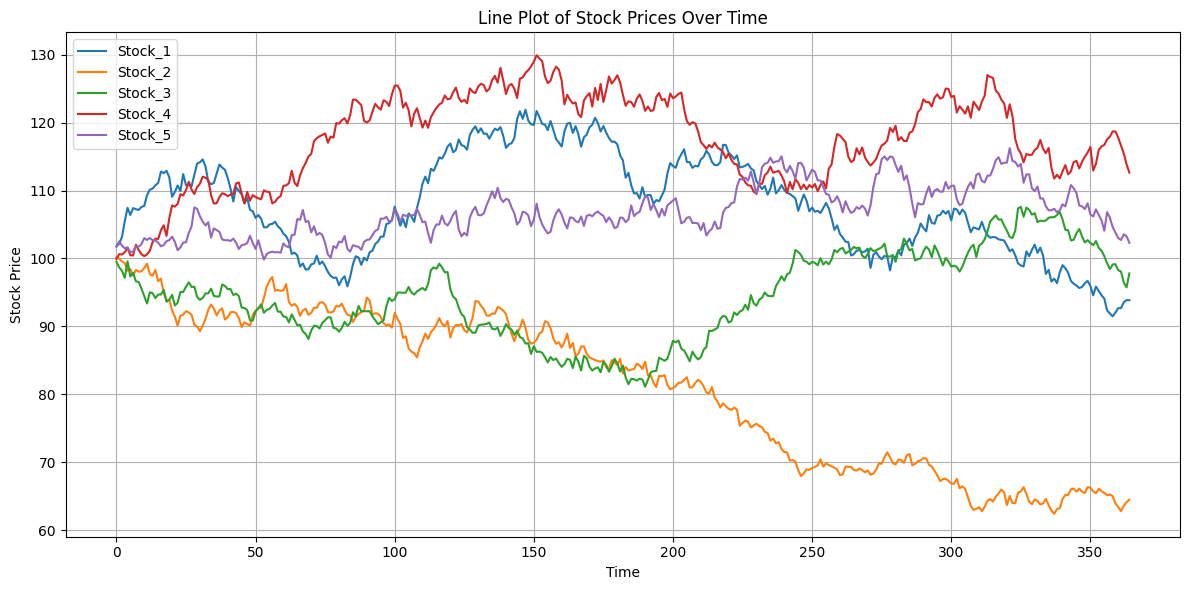

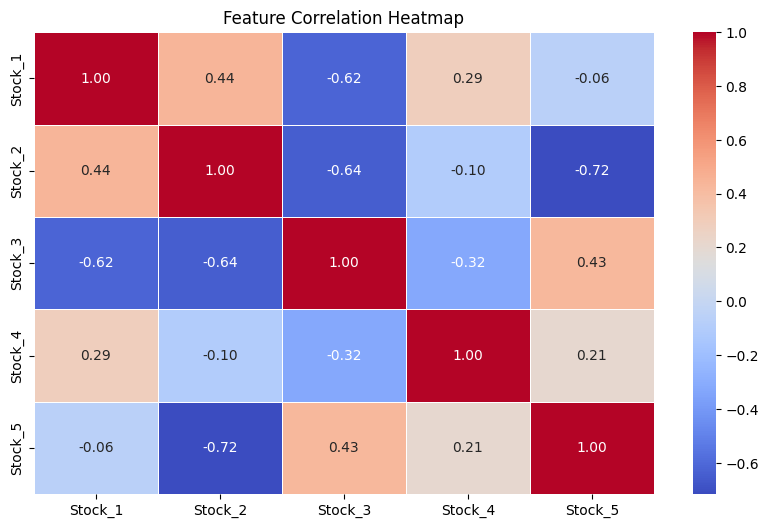

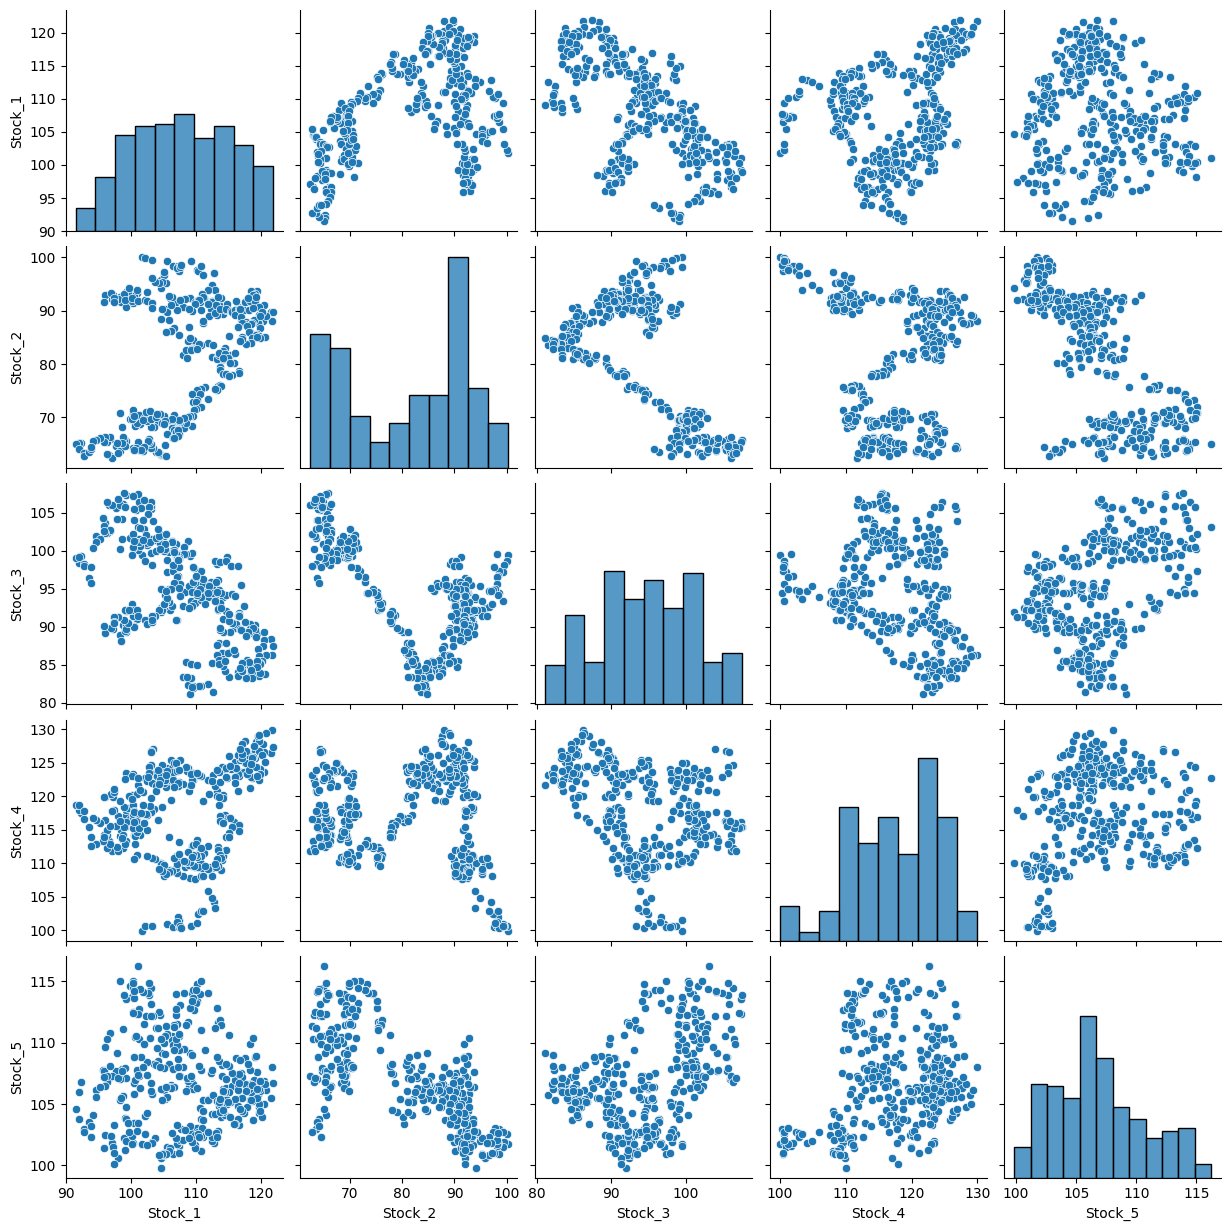

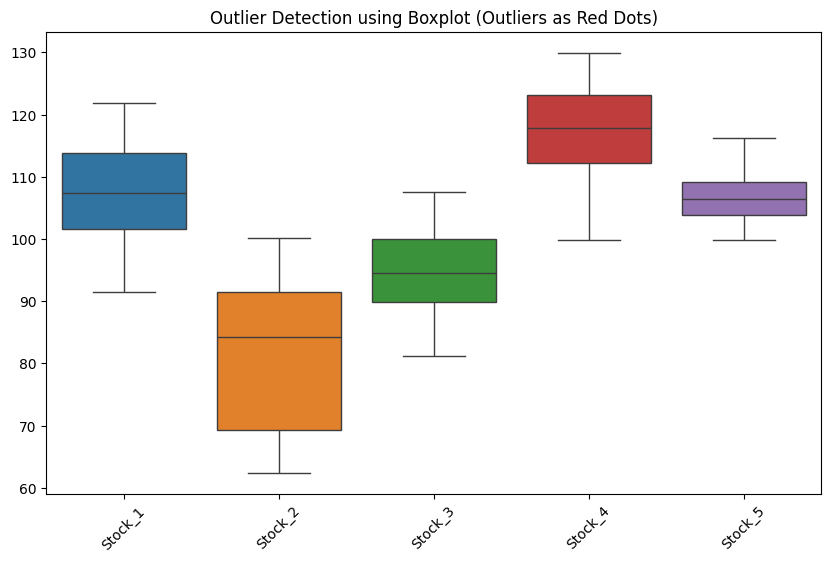

In [4]:
# Dataset file path
stock_data = "/content/drive/MyDrive/Machine Learning/stock_data.csv"

# Load the dataset
df = pd.read_csv(stock_data)
# Define features (X) and target (y)
X = df[['Stock_2', 'Stock_3', 'Stock_4', 'Stock_5']]  # Features (excluding Stock_1)
y = df['Stock_1']  # Target variable

# Check if X and y are correctly assigned
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Display first few rows
print("\n First 5 rows of the dataset: \n")
print(df.head())

# If your dataset has a date column (e.g., 'Date' or 'Unnamed: 0'), drop it
if df.columns[0] in ['Date', 'Unnamed: 0']:
    df.drop(df.columns[0], axis=1, inplace=True)

# Display descriptive statistics
print("\n Descriptive Statistics:\n")
print(df.describe())

# Check for missing values
print("\nMissing Values in Dataset:")
print(df.isnull().sum())

# Check data types
print("\nData Types:")
print(df.dtypes)

# Plot of Stocks over the year
plt.figure(figsize=(12, 6))

# Plot each stock
for col in ['Stock_1', 'Stock_2', 'Stock_3', 'Stock_4', 'Stock_5']:
    plt.plot(df.index, df[col], label=col)

# Styling
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Line Plot of Stock Prices Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot correlation heatmap (Pearson Corelation Coefficient)
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Pairplot to visualize relationships
sns.pairplot(df)
plt.show()

# Boxplot to detect outliers
flier_props = dict(marker='o', markerfacecolor='red', markersize=8, linestyle='none')

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, flierprops=flier_props)
plt.xticks(rotation=45)
plt.title("Outlier Detection using Boxplot (Outliers as Red Dots)")
plt.show()


 2. Data Preprocessing

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Remove any leading/trailing spaces in column names
df.columns = df.columns.str.strip()

# Define features and target variable
# NOTE: We now use other stocks to predict Stock_1.
features = ['Stock_2', 'Stock_3', 'Stock_4', 'Stock_5']
target = 'Stock_1'

# Remove duplicates
df = df.drop_duplicates()

# Handle missing values (replace NaNs with mean)
imputer = SimpleImputer(strategy="mean")
df[features] = imputer.fit_transform(df[features])
df[[target]] = imputer.fit_transform(df[[target]])

# Detect & remove outliers using IQR for features and target separately
Q1_features = df[features].quantile(0.25)
Q3_features = df[features].quantile(0.75)
IQR_features = Q3_features - Q1_features

Q1_target = df[target].quantile(0.25)
Q3_target = df[target].quantile(0.75)
IQR_target = Q3_target - Q1_target

df = df[
    ~(((df[features] < (Q1_features - 1.5 * IQR_features)) | (df[features] > (Q3_features + 1.5 * IQR_features))).any(axis=1))
    & ~((df[target] < (Q1_target - 1.5 * IQR_target)) | (df[target] > (Q3_target + 1.5 * IQR_target)))
]


3. Splitting Data and Standardize

In [6]:
# 1. First split: Train+Val and Test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Second split: Train and Val from remaining data
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

# Standardize (x-mean/std)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Training set: (233, 4), Validation set: (59, 4), Test set: (73, 4)


4. Feature Selection

In [7]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# ---- 1. Feature Selection using f_regression (Linear) ----
kbest_f = SelectKBest(score_func=f_regression, k=3)
X_train_f = kbest_f.fit_transform(X_train_scaled, y_train)
X_val_f = kbest_f.transform(X_val_scaled)
X_test_f = kbest_f.transform(X_test_scaled)

selected_indices_f = kbest_f.get_support(indices=True)
selected_features_f = [features[i] for i in selected_indices_f]

print("Top 3 features using f_regression (linear dependencies):", selected_features_f)

# ---- 2. Feature Selection using mutual_info_regression (Non-linear) ----
kbest_mi = SelectKBest(score_func=mutual_info_regression, k=3)
X_train_mi = kbest_mi.fit_transform(X_train_scaled, y_train)
X_val_mi = kbest_mi.transform(X_val_scaled)
X_test_mi = kbest_mi.transform(X_test_scaled)

selected_indices_mi = kbest_mi.get_support(indices=True)
selected_features_mi = [features[i] for i in selected_indices_mi]

print("Top 3 features using mutual_info_regression (non-linear dependencies):", selected_features_mi)

X_train_selected=X_train_mi
X_val_selected=X_val_mi
X_test_selected=X_test_mi


Top 3 features using f_regression (linear dependencies): ['Stock_2', 'Stock_3', 'Stock_4']
Top 3 features using mutual_info_regression (non-linear dependencies): ['Stock_2', 'Stock_3', 'Stock_4']


5. Train the model

In [8]:
# Create and train models
ridge_model = Ridge(alpha=10)
lasso_model = Lasso(alpha=0.1)
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())  # Degree 2
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

ridge_model.fit(X_train_selected, y_train)
lasso_model.fit(X_train_selected, y_train)
poly_model.fit(X_train_selected, y_train)
rf_model.fit(X_train_selected, y_train)

RandomForestRegressor(max_depth=5, random_state=42)

6. Evaluating the model's Performances

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
import pandas as pd

def evaluate_train(model, X_train, y_train):
    y_pred_train = model.predict(X_train)
    mae = mean_absolute_error(y_train, y_pred_train)
    mse = mean_squared_error(y_train, y_pred_train)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_train, y_pred_train)
    return mae, mse, rmse, r2

def evaluate_cv(model, X_train, y_train):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mae = -cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error').mean()
    mse = -cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error').mean()
    rmse = np.sqrt(mse)
    r2 = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2').mean()
    return mae, mse, rmse, r2

def evaluate_test(model, X_test, y_test):
    y_pred_test = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred_test)
    return mae, mse, rmse, r2


# Create Empty Lists
train_results = []
cv_results = []
test_results = []

# Models and their names
models = {
    'Ridge': ridge_model,
    'Lasso': lasso_model,
    'Polynomial Regression': poly_model,
    'Random Forest': rf_model,

}

# Evaluate Models
for name, model in models.items():
    # Training
    mae, mse, rmse, r2 = evaluate_train(model, X_train_selected, y_train)
    train_results.append((name, mae, mse, rmse, r2))

    # Cross Validation
    cv_mae, cv_mse, cv_rmse, cv_r2 = evaluate_cv(model, X_train_selected, y_train)
    cv_results.append((name, cv_mae, cv_mse, cv_rmse, cv_r2))

    # Testing
    test_mae, test_mse, test_rmse, test_r2 = evaluate_test(model, X_test_selected, y_test)
    test_results.append((name, test_mae, test_mse, test_rmse, test_r2))


# Display Results
train_df = pd.DataFrame(train_results, columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])
cv_df = pd.DataFrame(cv_results, columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])
test_df = pd.DataFrame(test_results, columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])

print("==== Training Performance ====")
print(train_df)
print("\n==== Cross Validation Performance ====")
print(cv_df)
print("\n==== Testing Performance ====")
print(test_df)


==== Training Performance ====
                   Model       MAE        MSE      RMSE        R2
0                  Ridge  4.472881  31.631981  5.624232  0.418273
1                  Lasso  4.469921  31.631806  5.624216  0.418276
2  Polynomial Regression  3.710128  19.415754  4.406331  0.642935
3          Random Forest  1.326789   3.181671  1.783724  0.941488

==== Cross Validation Performance ====
                   Model       MAE        MSE      RMSE        R2
0                  Ridge  4.519955  32.396276  5.691773  0.399729
1                  Lasso  4.516523  32.475797  5.698754  0.398464
2  Polynomial Regression  3.901154  21.366670  4.622410  0.604435
3          Random Forest  2.265467   9.016543  3.002756  0.832561

==== Testing Performance ====
                   Model       MAE        MSE      RMSE        R2
0                  Ridge  4.822742  37.090357  6.090185  0.227563
1                  Lasso  4.820824  37.007298  6.083362  0.229293
2  Polynomial Regression  3.679655  18.6

<ipython-input-10-bbe11764320c>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=metric, palette='coolwarm')


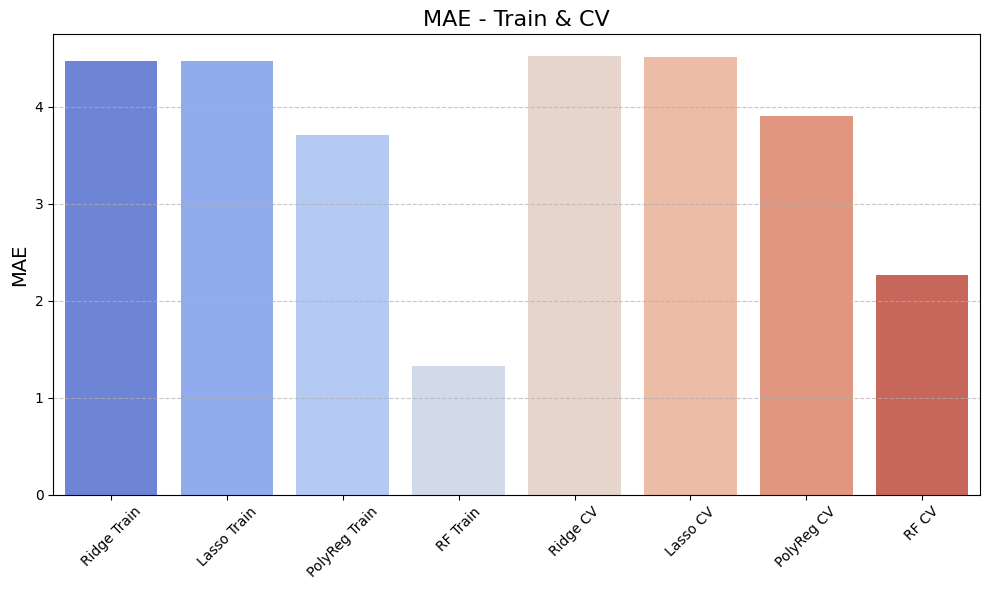

<ipython-input-10-bbe11764320c>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=metric, palette='coolwarm')


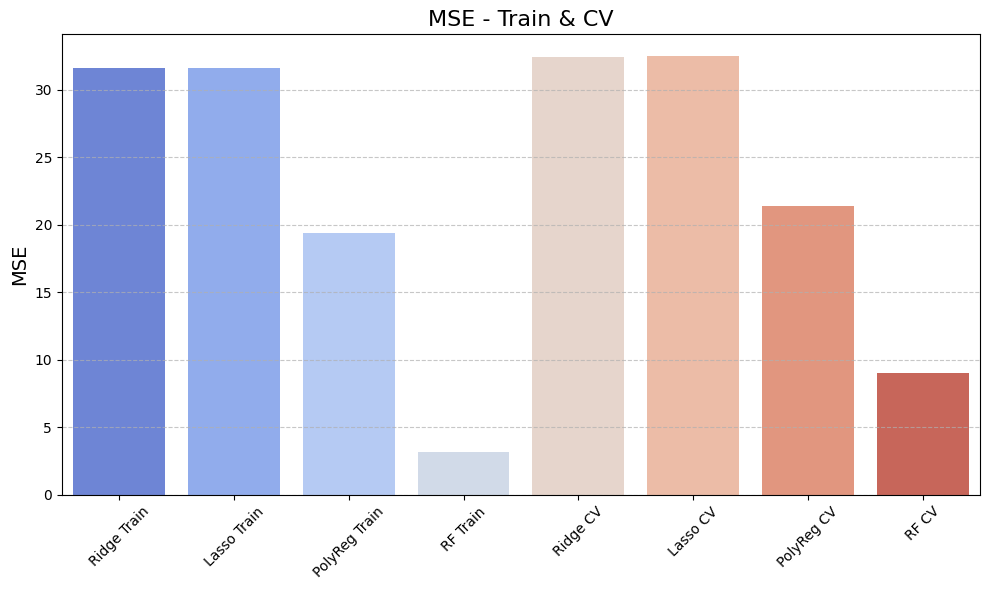

<ipython-input-10-bbe11764320c>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=metric, palette='coolwarm')


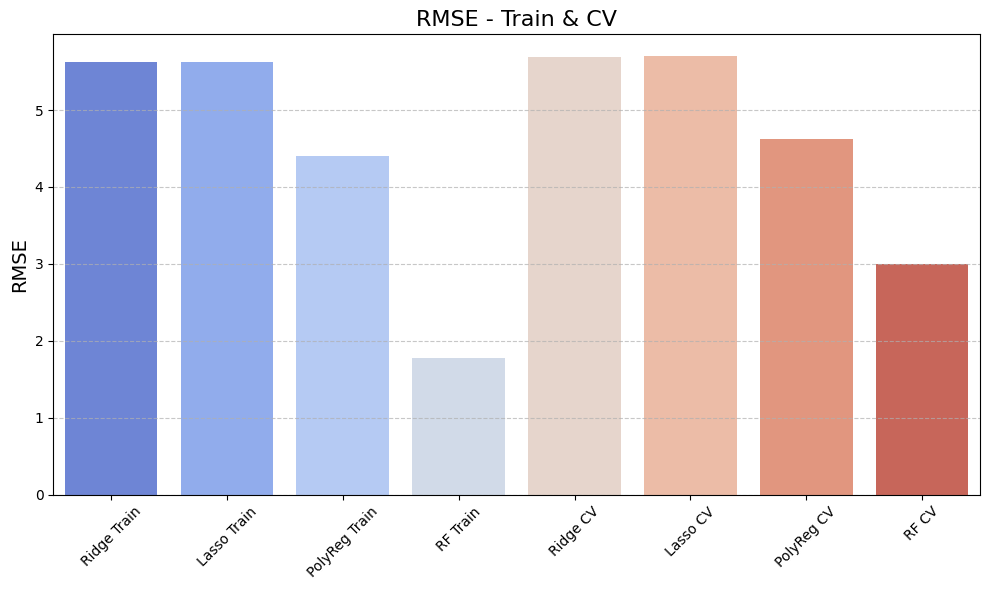

<ipython-input-10-bbe11764320c>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=metric, palette='coolwarm')


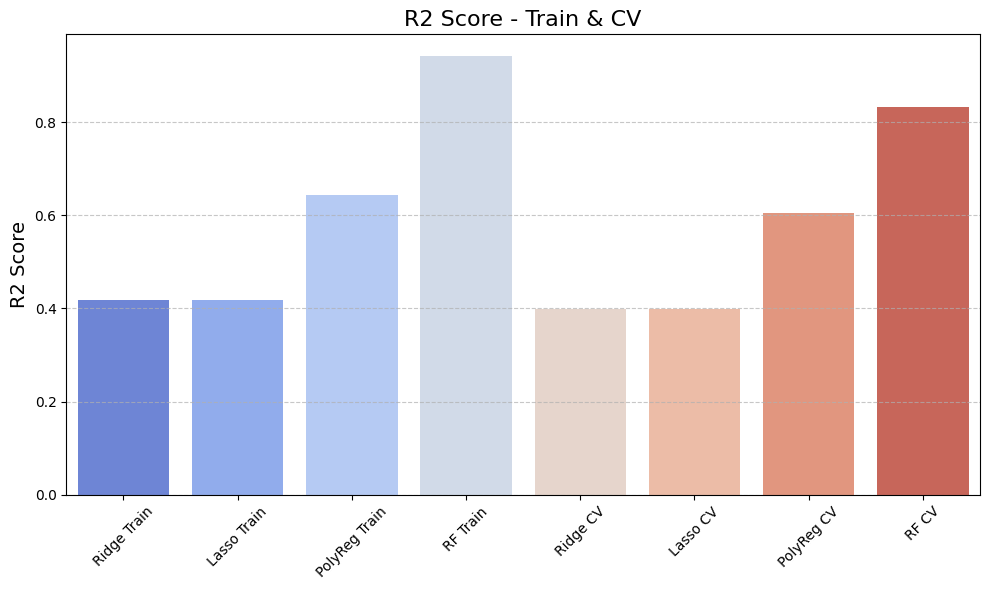

<ipython-input-10-bbe11764320c>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=metric, palette='coolwarm')


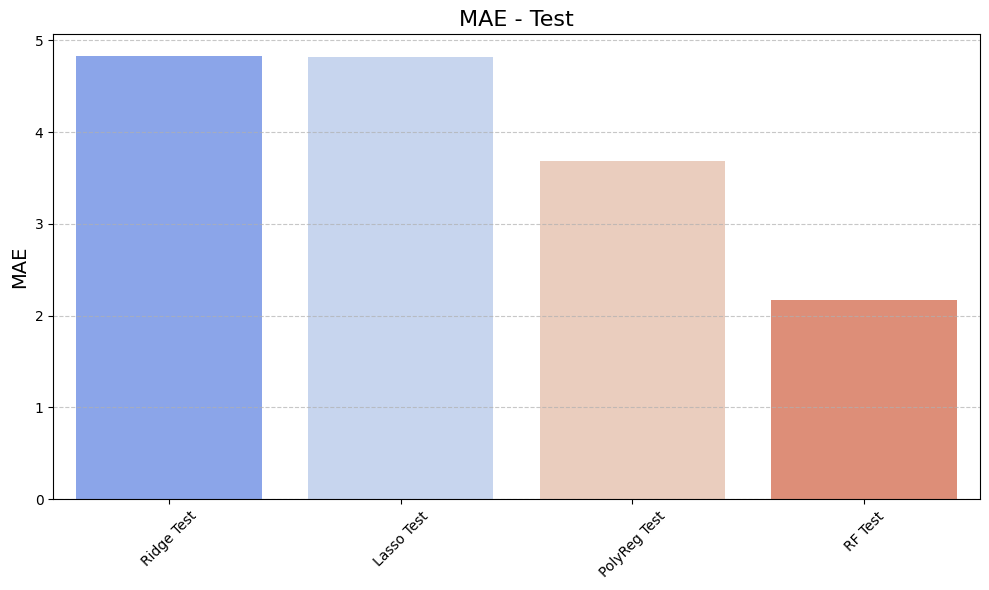

<ipython-input-10-bbe11764320c>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=metric, palette='coolwarm')


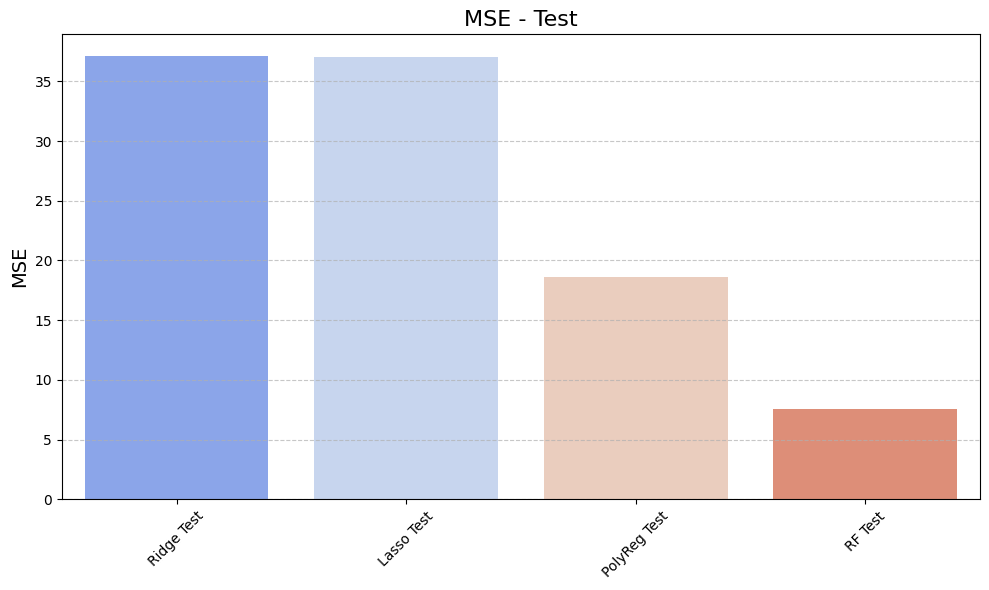

<ipython-input-10-bbe11764320c>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=metric, palette='coolwarm')


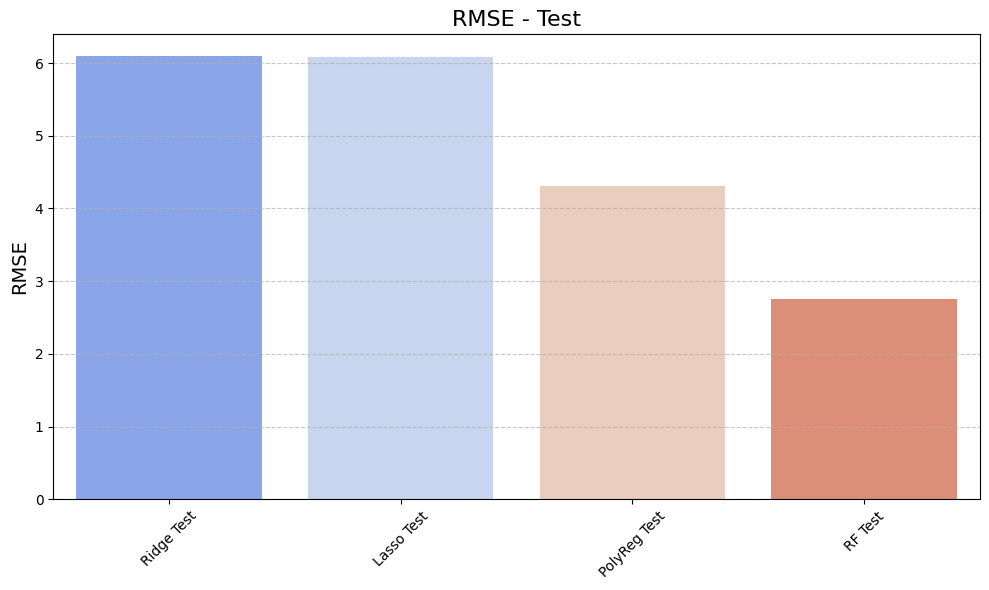

<ipython-input-10-bbe11764320c>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=metric, palette='coolwarm')


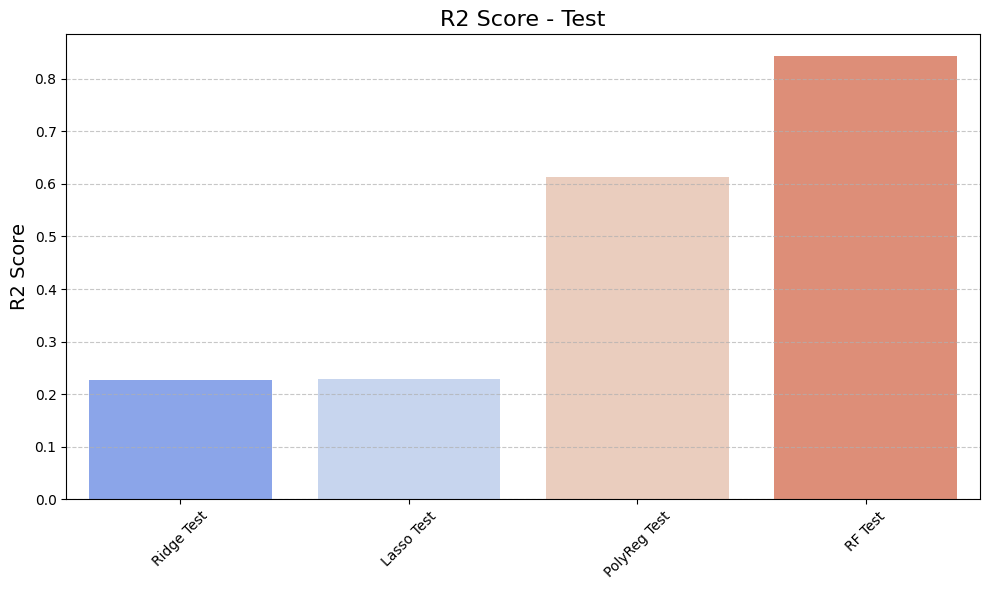

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Train + CV Data
mae_train_cv = list(train_df['MAE']) + list(cv_df['MAE'])
mse_train_cv = list(train_df['MSE']) + list(cv_df['MSE'])
rmse_train_cv = list(train_df['RMSE']) + list(cv_df['RMSE'])
r2_train_cv = list(train_df['R2']) + list(cv_df['R2'])

models_train_cv = ['Ridge Train', 'Lasso Train','PolyReg Train', 'RF Train',
                   'Ridge CV', 'Lasso CV', 'PolyReg CV', 'RF CV']

# Test Data
mae_test = list(test_df['MAE'])
mse_test = list(test_df['MSE'])
rmse_test = list(test_df['RMSE'])
r2_test = list(test_df['R2'])

models_test = ['Ridge Test', 'Lasso Test', 'PolyReg Test', 'RF Test']

# Plot Function
def plot_metric(metric, models, title, ylabel):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=models, y=metric, palette='coolwarm')
    plt.title(title, fontsize=16)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot Train + CV
plot_metric(mae_train_cv, models_train_cv, 'MAE - Train & CV', 'MAE')
plot_metric(mse_train_cv, models_train_cv, 'MSE - Train & CV', 'MSE')
plot_metric(rmse_train_cv, models_train_cv, 'RMSE - Train & CV', 'RMSE')
plot_metric(r2_train_cv, models_train_cv, 'R2 Score - Train & CV', 'R2 Score')

# Plot Test
plot_metric(mae_test, models_test, 'MAE - Test', 'MAE')
plot_metric(mse_test, models_test, 'MSE - Test', 'MSE')
plot_metric(rmse_test, models_test, 'RMSE - Test', 'RMSE')
plot_metric(r2_test, models_test, 'R2 Score - Test', 'R2 Score')



7. Predicting on 5 Samples from the Test Set


In [11]:
print("\nPredictions on 5 Random Test Samples:\n")

# Select 5 random samples from the test set
sample_indices = np.random.choice(X_test.shape[0], size=5, replace=False)

for i in sample_indices:
    # Original feature values (stock_2 to stock_5)
    stock_values = X_test.iloc[i]
    sample = stock_values.values.reshape(1, -1)

    # Convert to DataFrame with feature names to suppress warning
    sample_df = pd.DataFrame(sample, columns=X_test.columns)

    # Step 1: Standardize
    sample_scaled = scaler.transform(sample_df)

    # Step 2: Feature selection
    sample_selected = kbest_mi.transform(sample_scaled)

    # Step 3: Predictions
    pred_rf = rf_model.predict(sample_selected)
    pred_ridge = ridge_model.predict(sample_selected)
    pred_lasso = lasso_model.predict(sample_selected)
    pred_poly = poly_model.predict(sample_selected)

    # Step 4: Print details
    print(f"Test Sample {i + 1}:")
    print(f"  Stock_2 : {stock_values['Stock_2']:.4f}")
    print(f"  Stock_3 : {stock_values['Stock_3']:.4f}")
    print(f"  Stock_4 : {stock_values['Stock_4']:.4f}")
    print(f"  Stock_5 : {stock_values['Stock_5']:.4f}")
    print(f"  Actual Stock_1 (Target) : {y_test.iloc[i]:.4f}")
    print(f"  RF Prediction           : {pred_rf[0]:.4f}")
    print(f"  Ridge Prediction        : {pred_ridge[0]:.4f}")
    print(f"  Lasso Prediction        : {pred_lasso[0]:.4f}")
    print(f"  Poly Regression Pred    : {pred_poly[0]:.4f}\n")



Predictions on 5 Random Test Samples:

Test Sample 48:
  Stock_2 : 97.2733
  Stock_3 : 93.0633
  Stock_4 : 108.1078
  Stock_5 : 100.9957
  Actual Stock_1 (Target) : 105.0845
  RF Prediction           : 108.8748
  Ridge Prediction        : 108.5651
  Lasso Prediction        : 108.4990
  Poly Regression Pred    : 100.7993

Test Sample 61:
  Stock_2 : 72.7905
  Stock_3 : 95.9446
  Stock_4 : 112.7506
  Stock_5 : 114.2777
  Actual Stock_1 (Target) : 109.5798
  RF Prediction           : 110.6712
  Ridge Prediction        : 105.4593
  Lasso Prediction        : 105.6483
  Poly Regression Pred    : 108.6210

Test Sample 11:
  Stock_2 : 63.0974
  Stock_3 : 106.3871
  Stock_4 : 112.3240
  Stock_5 : 106.8021
  Actual Stock_1 (Target) : 96.3684
  RF Prediction           : 99.3989
  Ridge Prediction        : 99.0734
  Lasso Prediction        : 99.1116
  Poly Regression Pred    : 96.7382

Test Sample 37:
  Stock_2 : 93.0491
  Stock_3 : 91.7721
  Stock_4 : 112.9164
  Stock_5 : 103.4612
  Actual Stock

#Assignment 2

Applying Dimensionality Reduction and Hyper Parameter Tuning and comparing Performance

0. Load Nesscary Libraries

In [12]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

1. Dimensionality Reduction using PCA

In [13]:
# Perform PCA to reduce dimensions to 3 components for modeling
pca = PCA(n_components=3)  # Reduce to 3 principal components
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Evaluate the amount of variance explained by each component
print(f"Explained variance ratio by each component: {pca.explained_variance_ratio_}")

Explained variance ratio by each component: [0.68329055 0.23331371 0.05958974]


2. Plot PCA Vizualization

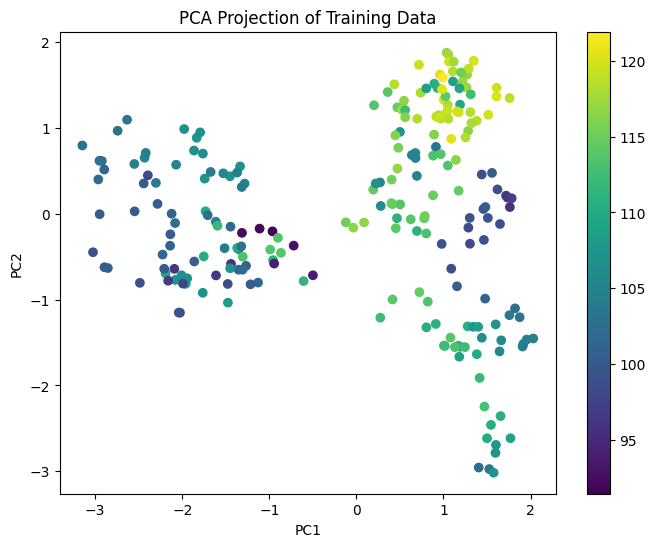

In [14]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis')
plt.colorbar()
plt.title('PCA Projection of Training Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


3. PCA vs No PCA (Random Forest)


In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
import numpy as np

# Train and Evaluate Original Features
rf_original = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)
rf_original.fit(X_train, y_train)
y_val_pred_orig = rf_original.predict(X_val)

mae_orig = mean_absolute_error(y_val, y_val_pred_orig)
mse_orig = mean_squared_error(y_val, y_val_pred_orig)
rmse_orig = np.sqrt(mse_orig)
r2_orig = r2_score(y_val, y_val_pred_orig)

# Apply PCA and Train on Transformed Features
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

rf_pca = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)
rf_pca.fit(X_train_pca, y_train)
y_val_pred_pca = rf_pca.predict(X_val_pca)

mae_pca = mean_absolute_error(y_val, y_val_pred_pca)
mse_pca = mean_squared_error(y_val, y_val_pred_pca)
rmse_pca = np.sqrt(mse_pca)
r2_pca = r2_score(y_val, y_val_pred_pca)

# 3. Compare Results
print("\nPerformance Comparison: Original Features vs PCA-transformed (Random Forest)")
print("-" * 60)
print(f"{'Metric':<10} | {'Original':<10} | {'PCA (3 comp)':<12}")
print("-" * 60)
print(f"{'MAE':<10} | {mae_orig:<10.4f} | {mae_pca:<12.4f}")
print(f"{'MSE':<10} | {mse_orig:<10.4f} | {mse_pca:<12.4f}")
print(f"{'RMSE':<10} | {rmse_orig:<10.4f} | {rmse_pca:<12.4f}")
print(f"{'R2':<10} | {r2_orig:<10.4f} | {r2_pca:<12.4f}")



Performance Comparison: Original Features vs PCA-transformed (Random Forest)
------------------------------------------------------------
Metric     | Original   | PCA (3 comp)
------------------------------------------------------------
MAE        | 2.9106     | 3.2470      
MSE        | 12.9058    | 15.7713     
RMSE       | 3.5925     | 3.9713      
R2         | 0.7770     | 0.7275      


PCA vs NO PCA (Polynomial Regression)

In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# ===== Polynomial Regression on Original Features (already trained as poly_model) =====
y_val_pred_poly_orig = poly_model.predict(kbest_mi.transform(scaler.transform(X_val)))

mae_poly_orig = mean_absolute_error(y_val, y_val_pred_poly_orig)
mse_poly_orig = mean_squared_error(y_val, y_val_pred_poly_orig)
rmse_poly_orig = np.sqrt(mse_poly_orig)
r2_poly_orig = r2_score(y_val, y_val_pred_poly_orig)

# ===== Polynomial Regression on PCA-transformed features =====
pca_poly = PCA(n_components=3)
X_train_pca_poly = pca_poly.fit_transform(X_train)
X_val_pca_poly = pca_poly.transform(X_val)

# Apply PolynomialFeatures to PCA-transformed data
poly_features_pca = PolynomialFeatures(degree=2)
X_train_poly_pca = poly_features_pca.fit_transform(X_train_pca_poly)
X_val_poly_pca = poly_features_pca.transform(X_val_pca_poly)

# Train Linear Regression on transformed PCA data
poly_model_pca = LinearRegression()
poly_model_pca.fit(X_train_poly_pca, y_train)
y_val_pred_poly_pca = poly_model_pca.predict(X_val_poly_pca)

mae_poly_pca = mean_absolute_error(y_val, y_val_pred_poly_pca)
mse_poly_pca = mean_squared_error(y_val, y_val_pred_poly_pca)
rmse_poly_pca = np.sqrt(mse_poly_pca)
r2_poly_pca = r2_score(y_val, y_val_pred_poly_pca)

print("\nPerformance Comparison: Polynomial Regression (Original vs PCA)")
print("-" * 60)
print(f"{'Metric':<10} | {'Poly (Orig)':<12} | {'Poly (PCA)':<12}")
print("-" * 60)
print(f"{'MAE':<10} | {mae_poly_orig:<12.4f} | {mae_poly_pca:<12.4f}")
print(f"{'MSE':<10} | {mse_poly_orig:<12.4f} | {mse_poly_pca:<12.4f}")
print(f"{'RMSE':<10} | {rmse_poly_orig:<12.4f} | {rmse_poly_pca:<12.4f}")
print(f"{'R2':<10} | {r2_poly_orig:<12.4f} | {r2_poly_pca:<12.4f}")




Performance Comparison: Polynomial Regression (Original vs PCA)
------------------------------------------------------------
Metric     | Poly (Orig)  | Poly (PCA)  
------------------------------------------------------------
MAE        | 3.3707       | 3.5757      
MSE        | 16.0861      | 17.3952     
RMSE       | 4.0108       | 4.1707      
R2         | 0.7221       | 0.6994      


Performance Comparsion (PCA vs NO PCA)

In [17]:
print("\nPerformance Comparison: Random Forest vs Polynomial Regression (Original vs PCA)")
print("-" * 80)
print(f"{'Metric':<10} | {'RF (Orig)':<12} | {'RF (PCA)':<12} | {'Poly (Orig)':<12} | {'Poly (PCA)':<12}")
print("-" * 80)
print(f"{'MAE':<10} | {mae_orig:<12.4f} | {mae_pca:<12.4f} | {mae_poly_orig:<12.4f} | {mae_poly_pca:<12.4f}")
print(f"{'MSE':<10} | {mse_orig:<12.4f} | {mse_pca:<12.4f} | {mse_poly_orig:<12.4f} | {mse_poly_pca:<12.4f}")
print(f"{'RMSE':<10} | {rmse_orig:<12.4f} | {rmse_pca:<12.4f} | {rmse_poly_orig:<12.4f} | {rmse_poly_pca:<12.4f}")
print(f"{'R2':<10} | {r2_orig:<12.4f} | {r2_pca:<12.4f} | {r2_poly_orig:<12.4f} | {r2_poly_pca:<12.4f}")



Performance Comparison: Random Forest vs Polynomial Regression (Original vs PCA)
--------------------------------------------------------------------------------
Metric     | RF (Orig)    | RF (PCA)     | Poly (Orig)  | Poly (PCA)  
--------------------------------------------------------------------------------
MAE        | 2.9106       | 3.2470       | 3.3707       | 3.5757      
MSE        | 12.9058      | 15.7713      | 16.0861      | 17.3952     
RMSE       | 3.5925       | 3.9713       | 4.0108       | 4.1707      
R2         | 0.7770       | 0.7275       | 0.7221       | 0.6994      


4. Hyper-parameter Tuning

5. Grid Search

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ---- Random Forest Grid Search ----
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                       param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=1)
grid_rf.fit(X_train_pca, y_train)
best_rf_grid = grid_rf.best_estimator_
pred_rf_grid = best_rf_grid.predict(X_val_pca)

mae_rf_grid = mean_absolute_error(y_val, pred_rf_grid)
mse_rf_grid = mean_squared_error(y_val, pred_rf_grid)
rmse_rf_grid = np.sqrt(mse_rf_grid)
r2_rf_grid = r2_score(y_val, pred_rf_grid)

# ---- Polynomial Regression Grid Search ----
poly_pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('linreg', LinearRegression())
])

param_grid_poly = {
    'poly__degree': [2, 3, 4],
    'poly__include_bias': [False],
    'linreg__fit_intercept': [True, False]
}

grid_poly = GridSearchCV(estimator=poly_pipeline,
                         param_grid=param_grid_poly, cv=5, n_jobs=-1, verbose=1)
grid_poly.fit(X_train_pca, y_train)
best_poly_grid = grid_poly.best_estimator_
pred_poly_grid = best_poly_grid.predict(X_val_pca)

mae_poly_grid = mean_absolute_error(y_val, pred_poly_grid)
mse_poly_grid = mean_squared_error(y_val, pred_poly_grid)
rmse_poly_grid = np.sqrt(mse_poly_grid)
r2_poly_grid = r2_score(y_val, pred_poly_grid)

print("Best Hyperparameters for Random Forest Regressor:")
print(grid_rf.best_params_)

# Print Best Hyperparameters for Polynomial Regression
print("\nBest Hyperparameters for Polynomial Regression:")
print(grid_poly.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Hyperparameters for Random Forest Regressor:
{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}

Best Hyperparameters for Polynomial Regression:
{'linreg__fit_intercept': True, 'poly__degree': 4, 'poly__include_bias': False}


6. Randomized Search

In [19]:
# ---- Random Forest Randomized Search ----
param_dist_rf = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 3, 5, 8],
    'min_samples_leaf': [1, 2, 4]
}

random_rf = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
                               param_distributions=param_dist_rf,
                               n_iter=10, cv=5, n_jobs=-1, random_state=42, verbose=1)
random_rf.fit(X_train_pca, y_train)
best_rf_random = random_rf.best_estimator_
pred_rf_random = best_rf_random.predict(X_val_pca)

mae_rf_random = mean_absolute_error(y_val, pred_rf_random)
mse_rf_random = mean_squared_error(y_val, pred_rf_random)
rmse_rf_random = np.sqrt(mse_rf_random)
r2_rf_random = r2_score(y_val, pred_rf_random)

# ---- Polynomial Regression Randomized Search ----
param_dist_poly = {
    'poly__degree': [2, 3, 4, 5],
    'poly__include_bias': [True, False],
    'linreg__fit_intercept': [True, False]
}

random_poly = RandomizedSearchCV(estimator=poly_pipeline,
                                 param_distributions=param_dist_poly,
                                 n_iter=10, cv=5, n_jobs=-1, random_state=42, verbose=1)
random_poly.fit(X_train_pca, y_train)
best_poly_random = random_poly.best_estimator_
pred_poly_random = best_poly_random.predict(X_val_pca)

mae_poly_random = mean_absolute_error(y_val, pred_poly_random)
mse_poly_random = mean_squared_error(y_val, pred_poly_random)
rmse_poly_random = np.sqrt(mse_poly_random)
r2_poly_random = r2_score(y_val, pred_poly_random)

# Print Best Hyperparameters for Random Forest (Randomized Search)
print("Best Hyperparameters for Random Forest Regressor (Randomized Search):")
print(random_rf.best_params_)

# Print Best Hyperparameters for Polynomial Regression (Randomized Search)
print("\nBest Hyperparameters for Polynomial Regression (Randomized Search):")
print(random_poly.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters for Random Forest Regressor (Randomized Search):
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 15}

Best Hyperparameters for Polynomial Regression (Randomized Search):
{'poly__include_bias': False, 'poly__degree': 4, 'linreg__fit_intercept': True}


7. Comparing Results

In [20]:
import pandas as pd

# Printing the Performance Comparison Table
print("\nPerformance Comparison: Grid vs Random Search (Random Forest & Polynomial Regression)")
print("-" * 90)
print(f"{'Metric':<10} | {'RF-Grid':<12} | {'RF-Random':<12} | {'Poly-Grid':<12} | {'Poly-Random':<12}")
print("-" * 90)
print(f"{'MAE':<10} | {mae_rf_grid:<12.4f} | {mae_rf_random:<12.4f} | {mae_poly_grid:<12.4f} | {mae_poly_random:<12.4f}")
print(f"{'MSE':<10} | {mse_rf_grid:<12.4f} | {mse_rf_random:<12.4f} | {mse_poly_grid:<12.4f} | {mse_poly_random:<12.4f}")
print(f"{'RMSE':<10} | {rmse_rf_grid:<12.4f} | {rmse_rf_random:<12.4f} | {rmse_poly_grid:<12.4f} | {rmse_poly_random:<12.4f}")
print(f"{'R2':<10} | {r2_rf_grid:<12.4f} | {r2_rf_random:<12.4f} | {r2_poly_grid:<12.4f} | {r2_poly_random:<12.4f}")

print("-" * 90)

# Storing Metrics in a DataFrame for further use
performance_metrics = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'R2'],
    'RF_Grid': [mae_rf_grid, mse_rf_grid, rmse_rf_grid, r2_rf_grid],
    'RF_Random': [mae_rf_random, mse_rf_random, rmse_rf_random, r2_rf_random],
    'Poly_Grid': [mae_poly_grid, mse_poly_grid, rmse_poly_grid, r2_poly_grid],
    'Poly_Random': [mae_poly_random, mse_poly_random, rmse_poly_random, r2_poly_random]
}

performance_df = pd.DataFrame(performance_metrics)



Performance Comparison: Grid vs Random Search (Random Forest & Polynomial Regression)
------------------------------------------------------------------------------------------
Metric     | RF-Grid      | RF-Random    | Poly-Grid    | Poly-Random 
------------------------------------------------------------------------------------------
MAE        | 2.0851       | 2.1978       | 2.6697       | 2.6697      
MSE        | 8.7634       | 9.7340       | 10.4514      | 10.4514     
RMSE       | 2.9603       | 3.1199       | 3.2329       | 3.2329      
R2         | 0.8486       | 0.8318       | 0.8194       | 0.8194      
------------------------------------------------------------------------------------------


8. Plot the Results

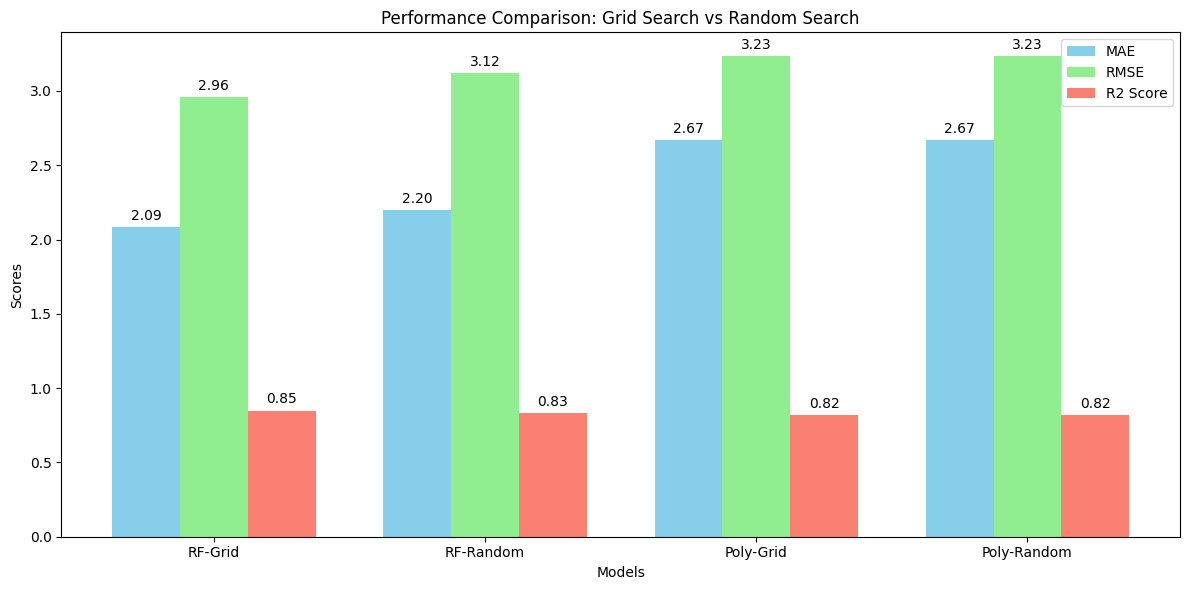

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Labels for Models
models = ['RF-Grid', 'RF-Random', 'Poly-Grid', 'Poly-Random']

# Metrics
mae_scores = [mae_rf_grid, mae_rf_random, mae_poly_grid, mae_poly_random]
rmse_scores = [rmse_rf_grid, rmse_rf_random, rmse_poly_grid, rmse_poly_random]
r2_scores = [r2_rf_grid, r2_rf_random, r2_poly_grid, r2_poly_random]

x = np.arange(len(models))  # Label locations
width = 0.25  # Bar width

fig, ax = plt.subplots(figsize=(12, 6))

# Plotting Bars
bar1 = ax.bar(x - width, mae_scores, width, label='MAE', color='skyblue')
bar2 = ax.bar(x, rmse_scores, width, label='RMSE', color='lightgreen')
bar3 = ax.bar(x + width, r2_scores, width, label='R2 Score', color='salmon')

# Adding Labels & Title
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison: Grid Search vs Random Search')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Adding score labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

plt.tight_layout()
plt.show()


GRID SEARCH IS BETTER, So using that for comparison


# MINI PROJECT - Ensembling Models

1. Ensembling Models: (Bagging, AdaBoost, GradientBoost)


In [22]:
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Features
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split the scaled data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

# Define a function to train and evaluate models
def train_and_evaluate(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    print(f"\n{name}")
    print("-" * len(name))
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    return model, mse, rmse, mae, r2

# 1. AdaBoost Regressor
ada_model = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3),
                              n_estimators=100, learning_rate=0.1, random_state=42)
ada_model, mse_ada, rmse_ada, mae_ada, r2_ada = train_and_evaluate(ada_model, "AdaBoost Regressor")

# 2. Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                     max_depth=3, random_state=42)
gb_model, mse_gb, rmse_gb, mae_gb, r2_gb = train_and_evaluate(gb_model, "Gradient Boosting Regressor")

# 3. Bagging Regressor
bag_model = BaggingRegressor(estimator=DecisionTreeRegressor(),
                             n_estimators=100, random_state=42)
bag_model, mse_bag, rmse_bag, mae_bag, r2_bag = train_and_evaluate(bag_model, "Bagging Regressor")



Training set: (204, 4), Validation set: (88, 4), Test set: (73, 4)

AdaBoost Regressor
------------------
Mean Absolute Error (MAE): 0.3134
Mean Squared Error (MSE): 0.1551
Root Mean Squared Error (RMSE): 0.3938
R² Score: 0.8401

Gradient Boosting Regressor
---------------------------
Mean Absolute Error (MAE): 0.3007
Mean Squared Error (MSE): 0.1573
Root Mean Squared Error (RMSE): 0.3967
R² Score: 0.8377

Bagging Regressor
-----------------
Mean Absolute Error (MAE): 0.2757
Mean Squared Error (MSE): 0.1429
Root Mean Squared Error (RMSE): 0.3780
R² Score: 0.8526


2. Selecting the best ensembling model

In [23]:
# Choose best model based on validation R²
best_model = gb_model
best_model_name = "Gradient Boosting Regressor"
if r2_ada > r2_gb and r2_ada > r2_bag:
    best_model = ada_model
    best_model_name = "AdaBoost Regressor"
elif r2_bag > r2_gb and r2_bag > r2_ada:
    best_model = bag_model
    best_model_name = "Bagging Regressor"

# Evaluate best model on test set
y_test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nTest Set Evaluation (using best model - {best_model_name}):")
print("-" * 50)
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"Mean Squared Error (MSE): {test_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"R² Score: {test_r2:.4f}")



Test Set Evaluation (using best model - Bagging Regressor):
--------------------------------------------------
Mean Absolute Error (MAE): 0.2675
Mean Squared Error (MSE): 0.1342
Root Mean Squared Error (RMSE): 0.3664
R² Score: 0.8474


# Choosing the best Model

In [24]:
import pandas as pd
import numpy as np

# Dictionary to hold model performance
model_metrics = {
    'Model': [],
    'MAE': [],
    'MSE': [],
    'RMSE': [],
    'R2': []
}

ridge_test_metrics = test_df[test_df['Model'] == 'Ridge']

mae_ridge = ridge_test_metrics['MAE'].values[0]
mse_ridge = ridge_test_metrics['MSE'].values[0]
rmse_ridge = ridge_test_metrics['RMSE'].values[0]
r2_ridge = ridge_test_metrics['R2'].values[0]

lasso_test = test_df[test_df['Model'] == 'Lasso']

mae_lasso = lasso_test['MAE'].values[0]
mse_lasso = lasso_test['MSE'].values[0]
rmse_lasso = lasso_test['RMSE'].values[0]
r2_lasso = lasso_test['R2'].values[0]

poly_test = test_df[test_df['Model'] == 'Polynomial Regression']

mae_poly = poly_test['MAE'].values[0]
mse_poly = poly_test['MSE'].values[0]
rmse_poly = poly_test['RMSE'].values[0]
r2_poly = poly_test['R2'].values[0]

rf_test = test_df[test_df['Model'] == 'Random Forest']

mae_rf = rf_test['MAE'].values[0]
mse_rf = rf_test['MSE'].values[0]
rmse_rf = rf_test['RMSE'].values[0]
r2_rf = rf_test['R2'].values[0]

metrics = ['MAE', 'MSE', 'RMSE', 'R2']
models = ['RF_Grid', 'RF_Random', 'Poly_Grid', 'Poly_Random']

# Random Forest - Base
mae_rf = performance_df.loc[performance_df['Metric'] == 'MAE', 'RF_Grid'].values[0]
mse_rf = performance_df.loc[performance_df['Metric'] == 'MSE', 'RF_Grid'].values[0]
rmse_rf = performance_df.loc[performance_df['Metric'] == 'RMSE', 'RF_Grid'].values[0]
r2_rf = performance_df.loc[performance_df['Metric'] == 'R2', 'RF_Grid'].values[0]

# Grid-RF
mae_grid_rf = performance_df.loc[performance_df['Metric'] == 'MAE', 'RF_Grid'].values[0]
mse_grid_rf = performance_df.loc[performance_df['Metric'] == 'MSE', 'RF_Grid'].values[0]
rmse_grid_rf = performance_df.loc[performance_df['Metric'] == 'RMSE', 'RF_Grid'].values[0]
r2_grid_rf = performance_df.loc[performance_df['Metric'] == 'R2', 'RF_Grid'].values[0]

# Random-RF
mae_random_rf = performance_df.loc[performance_df['Metric'] == 'MAE', 'RF_Random'].values[0]
mse_random_rf = performance_df.loc[performance_df['Metric'] == 'MSE', 'RF_Random'].values[0]
rmse_random_rf = performance_df.loc[performance_df['Metric'] == 'RMSE', 'RF_Random'].values[0]
r2_random_rf = performance_df.loc[performance_df['Metric'] == 'R2', 'RF_Random'].values[0]

# Grid-Poly
mae_grid_poly = performance_df.loc[performance_df['Metric'] == 'MAE', 'Poly_Grid'].values[0]
mse_grid_poly = performance_df.loc[performance_df['Metric'] == 'MSE', 'Poly_Grid'].values[0]
rmse_grid_poly = performance_df.loc[performance_df['Metric'] == 'RMSE', 'Poly_Grid'].values[0]
r2_grid_poly = performance_df.loc[performance_df['Metric'] == 'R2', 'Poly_Grid'].values[0]

# Random-Poly
mae_random_poly = performance_df.loc[performance_df['Metric'] == 'MAE', 'Poly_Random'].values[0]
mse_random_poly = performance_df.loc[performance_df['Metric'] == 'MSE', 'Poly_Random'].values[0]
rmse_random_poly = performance_df.loc[performance_df['Metric'] == 'RMSE', 'Poly_Random'].values[0]
r2_random_poly = performance_df.loc[performance_df['Metric'] == 'R2', 'Poly_Random'].values[0]


models_data = [
    ('Ridge', mae_ridge, mse_ridge, rmse_ridge, r2_ridge),
    ('Lasso', mae_lasso, mse_lasso, rmse_lasso, r2_lasso),
    ('Base Poly', mae_poly, mse_poly, rmse_poly, r2_poly),
    ('Random Forest', mae_rf, mse_rf, rmse_rf, r2_rf),
    ('Grid-RF', mae_grid_rf, mse_grid_rf, rmse_grid_rf, r2_grid_rf),
    ('Random-RF', mae_random_rf, mse_random_rf, rmse_random_rf, r2_random_rf),
    ('Grid-Poly', mae_grid_poly, mse_grid_poly, rmse_grid_poly, r2_grid_poly),
    ('Random-Poly', mae_random_poly, mse_random_poly, rmse_random_poly, r2_random_poly),
    ('AdaBoost', mae_ada, mse_ada, rmse_ada, r2_ada),
    ('Gradient Boosting', mae_gb, mse_gb, rmse_gb, r2_gb),
    ('Bagging Regressor', mae_bag, mse_bag, rmse_bag, r2_bag)
]

# Populate the dictionary
for name, mae, mse, rmse, r2 in models_data:
    model_metrics['Model'].append(name)
    model_metrics['MAE'].append(mae)
    model_metrics['MSE'].append(mse)
    model_metrics['RMSE'].append(rmse)
    model_metrics['R2'].append(r2)

# Create DataFrame
results_df = pd.DataFrame(model_metrics)

# Display sorted by highest R²
results_sorted = results_df.sort_values(by='R2', ascending=False).reset_index(drop=True)
print("\nModel Comparison (Sorted by R²):")
print(results_sorted)

# Identify the best model
best_model_row = results_sorted.iloc[0]
best_model_name = best_model_row['Model']

print(f"\n Best Performing Model: {best_model_name}")
print(f"   - R² Score: {best_model_row['R2']:.4f}")
print(f"   - RMSE    : {best_model_row['RMSE']:.4f}")
print(f"   - MAE     : {best_model_row['MAE']:.4f}")

# Fetch specific metrics from the DataFrame
ridge_test_mae = results_df.loc[results_df['Model'] == 'Ridge', 'MAE'].values[0]
lasso_test_rmse = results_df.loc[results_df['Model'] == 'Lasso', 'RMSE'].values[0]
polyreg_test_r2 = results_df.loc[results_df['Model'] == 'Base Poly', 'R2'].values[0]
rf_test_mse = results_df.loc[results_df['Model'] == 'Random Forest', 'MSE'].values[0]


Model Comparison (Sorted by R²):
                Model       MAE        MSE      RMSE        R2
0   Bagging Regressor  0.275718   0.142867  0.377977  0.852637
1       Random Forest  2.085107   8.763410  2.960306  0.848583
2             Grid-RF  2.085107   8.763410  2.960306  0.848583
3            AdaBoost  0.313448   0.155051  0.393765  0.840069
4   Gradient Boosting  0.300701   0.157339  0.396660  0.837708
5           Random-RF  2.197838   9.733987  3.119934  0.831813
6           Grid-Poly  2.669681  10.451375  3.232859  0.819418
7         Random-Poly  2.669681  10.451375  3.232859  0.819418
8           Base Poly  3.679655  18.610668  4.314008  0.612418
9               Lasso  4.820824  37.007298  6.083362  0.229293
10              Ridge  4.822742  37.090357  6.090185  0.227563

 Best Performing Model: Bagging Regressor
   - R² Score: 0.8526
   - RMSE    : 0.3780
   - MAE     : 0.2757


Vizualization of Results

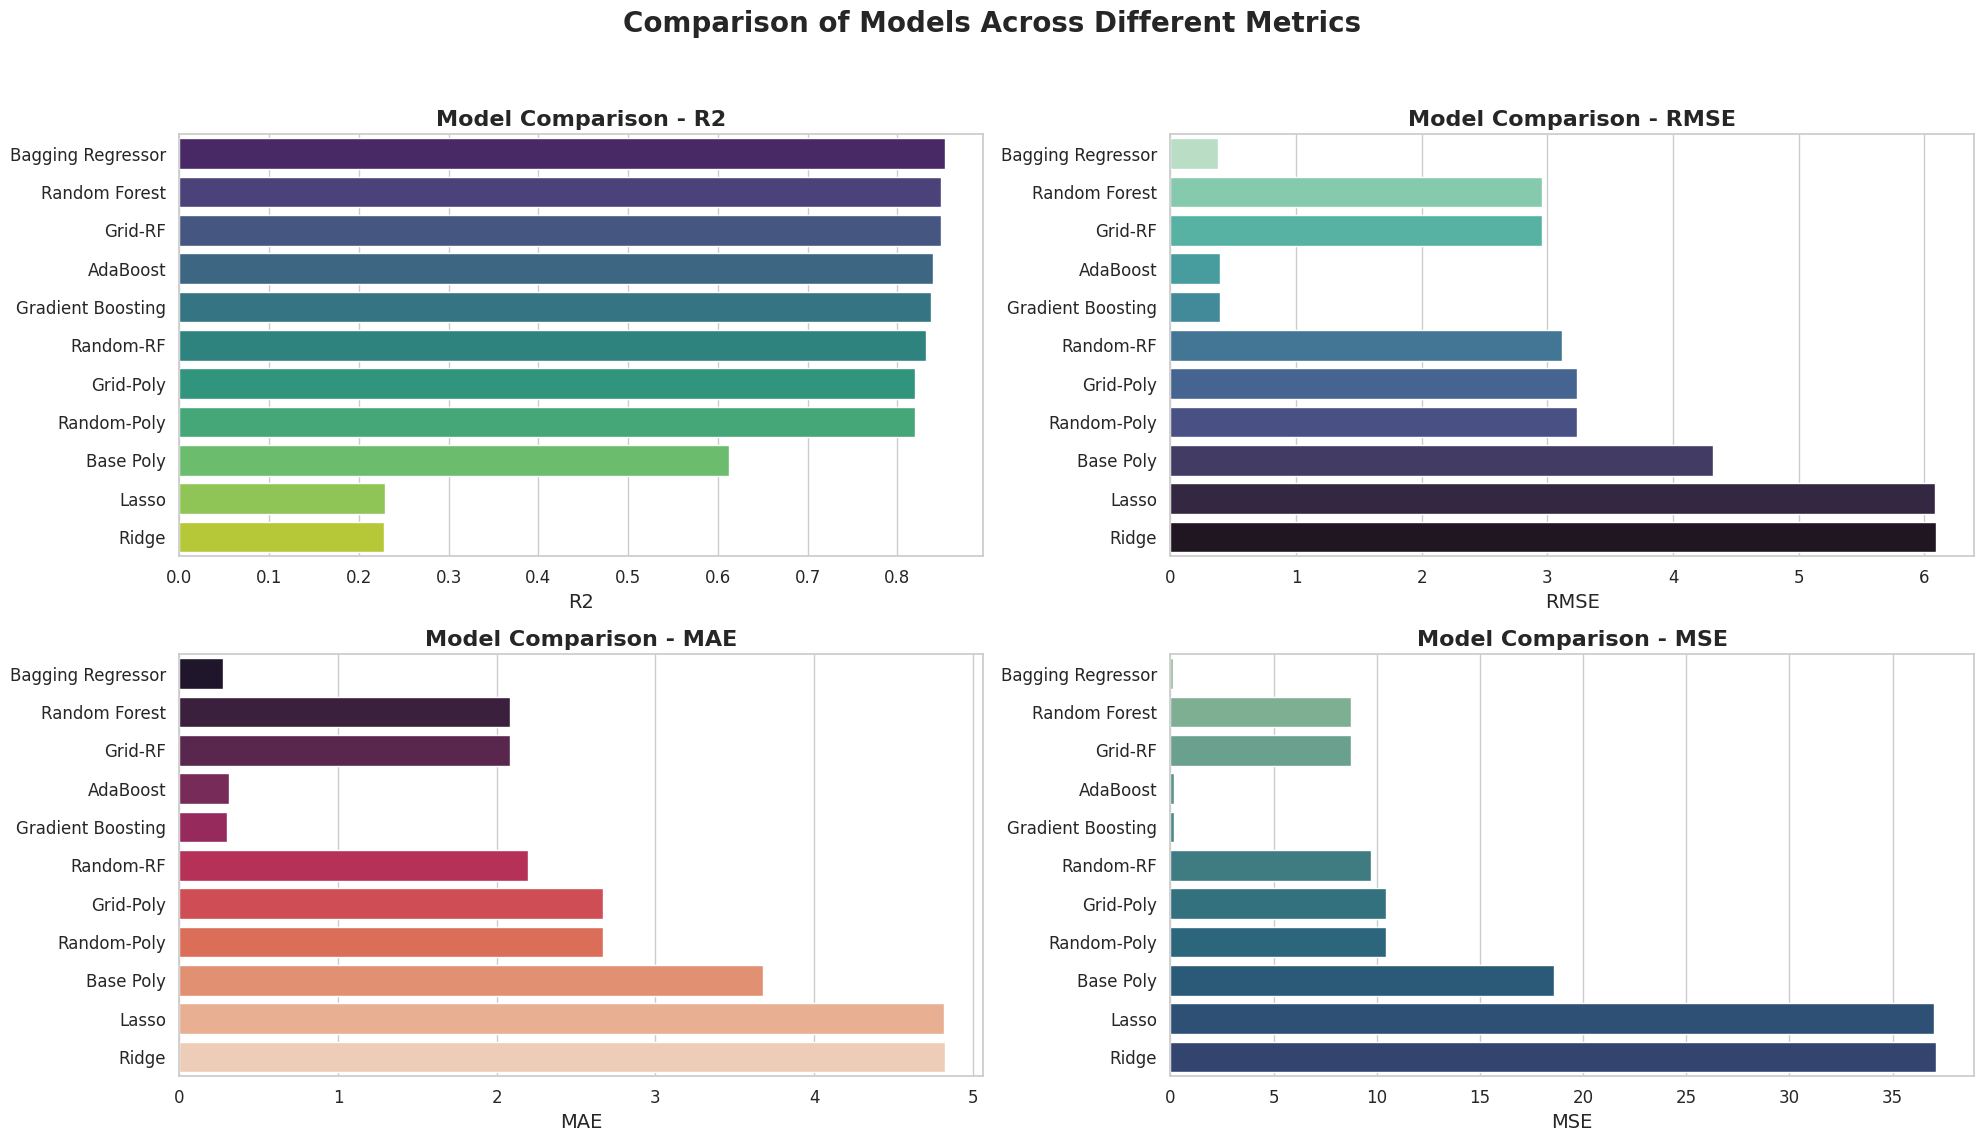

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn theme
sns.set(style="whitegrid")

# Define your models exactly as per your data
model_names = [
    'Bagging Regressor', 'Random Forest', 'Grid-RF', 'AdaBoost',
    'Gradient Boosting', 'Random-RF', 'Grid-Poly', 'Random-Poly',
    'Base Poly', 'Lasso', 'Ridge'
]

# Create 2x2 subplots for R2, RMSE, MAE, MSE
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

metrics = ['R2', 'RMSE', 'MAE', 'MSE']
palettes = ['viridis', 'mako_r', 'rocket', 'crest']

# Plot each metric
for ax, metric, palette in zip(axes.flat, metrics, palettes):
    sns.barplot(
        ax=ax,
        y='Model',
        x=metric,
        hue='Model',
        data=results_sorted[results_sorted['Model'].isin(model_names)],
        palette=palette,
        legend=False
    )
    ax.set_title(f'Model Comparison - {metric}', fontsize=16, fontweight='bold')
    ax.set_xlabel(metric, fontsize=14)
    ax.set_ylabel("")
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

plt.suptitle('Comparison of Models Across Different Metrics', fontsize=20, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
